In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 19 17:08:19 2024

@author: Rodrigo Meira
"""

from libs.eos_database import *
from libs.compressor_class import *
from libs.compression import *
from libs.gc_eos_soave import *
from casadi import *
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.plenum_system import *

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

vlv = valve(kv=0.38)
Vpp = 2.0 
Lc = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4500, None, 1, 0, Aij, volumn_desviation, 'gas')
comp = CompressorClass()
visc = viscosity(mixture, volumn_desviation)
compressor = compression(gas, comp, visc)
plenum_sys = plenum(gas, compressor, vlv, Vpp, Lc, A1)
nAlphas = 6
alphas = np.random.uniform(0.35,0.65, nAlphas+1)
nData = 2000
dt = 0.1

In [4]:
n_x = 3
n_z = 11

def system_residuals(y, u0, plenum_sys):
    # Separa as variáveis
    x = y[:n_x]
    z = y[n_x:]
    
    # Substitua as expressões abaixo pelas suas equações do modelo em estado estacionário.
    ode_sym, alg_sym = plenum_sys.evaluate_dae(None, x, z, u0)
    
    res_ode = np.array([ode_sym[i].item() for i in range(n_x)])
    
    # Calcula os resíduos das equações algébricas
    res_alg = np.array([alg_sym[i] for i in range(n_z)])

    res = np.concatenate((res_ode, res_alg))
    return res

def compute_steady_state(u0, plenum_sys, x0, z0):
    # Vetor inicial concatenado
    y0 = np.array(x0 + z0)
    
    # Chama o fsolve para encontrar os zeros da função de resíduos
    sol = fsolve(system_residuals, y0, args=(u0, plenum_sys))
    
    # Separa a solução em x e z
    x_ss = sol[:n_x]
    z_ss = sol[n_x:]
    return x_ss, z_ss

if __name__ == '__main__':
    Phi, eta, Mach, Gimp, G2, Gdif, PHI, G2s, k = compression.character(compressor, m = 10, N = 750, Gi_1 = gas)
    x0 = [14.9919, 339.69, 0.42885]
    # E z0 pode ser (conforme seu código original):
    z0 = [6245.39, 6245.39, 321.672, 0.445562, 319.423, 0.503621, 320.097, 0.396345, 339.69, 0.42885, 0.514917]
    u0 = [4500, 300, 750, alphas[0], 5000]
    
    # Calcula os estados estacionários
    x_ss, z_ss = compute_steady_state(u0, plenum_sys, x0, z0)
    print("Estado estacionário (variáveis diferenciais):", x_ss)
    print("Estado estacionário (variáveis algébricas):", z_ss)

Estado estacionário (variáveis diferenciais): [1.23623332e+01 3.52444277e+02 2.99672896e-01]
Estado estacionário (variáveis algébricas): [9.24997028e+03 9.24997028e+03 3.23567940e+02 4.23238463e-01
 3.22417271e+02 4.42507242e-01 3.43889553e+02 2.89718969e-01
 3.52444277e+02 2.99672896e-01 5.14917237e-01]


In [5]:
def test_evaluate_dae(plenum_sys, x_test, z_test, u0):# Parâmetros de entrada

    # Avaliação da função
    ode_values, alg_values = plenum_sys.evaluate_dae(None, x_ss, z_ss, u0)

    # Imprimindo os resultados
    print("Valores das ODEs:")
    for i, val in enumerate(ode_values):
        print(f"ODE {i}: {val}")

    print("\nValores das equações algébricas:")
    for i, val in enumerate(alg_values):
        print(f"Algebrica {i}: {val}")
    return ode_values, alg_values
ode_values, alg_values = test_evaluate_dae(plenum_sys, x_ss, z_ss, u0)

Valores das ODEs:
ODE 0: 0.0
ODE 1: 2.095336784230065e-09
ODE 2: 4.932229075169442e-12

Valores das equações algébricas:
Algebrica 0: -5.11186954099685e-07
Algebrica 1: -4.419016477186233e-07
Algebrica 2: 1.6106523729373316e-12
Algebrica 3: -3.1672993211168465e-11
Algebrica 4: -2.613951615725158e-12
Algebrica 5: -4.979806715554837e-11
Algebrica 6: -1.2985435660084477e-07
Algebrica 7: 7.685230229981244e-11
Algebrica 8: 5.963255489405128e-08
Algebrica 9: 7.697999535594136e-07
Algebrica 10: 0.0


In [29]:
# def run_simulation(x0, z0, plenum_sys):
#     u0 = [4500, 300, 750, 0.65, 5000]
#     # Definição dos símbolos
#     x_sym = SX.sym('x', 3)
#     z_sym = SX.sym('z', 11)
#     u_sym = SX.sym('u', 5)
#     for i in range(nAlphas):
#         alpha_value = alphas[i] + np.random.normal(0, 0, nData)
#         integrator_solver = integrator('F', 'idas', dae, 0, 100)
#         res = integrator_solver(x0=x0, z0=z0, p=u0)

#         ode_sym, alg_sym = plenum_sys.evaluate_dae(None, x_sym, z_sym, u_sym)
#         for j in range(self.nData):
#                 params = [alpha_value[j], N_value[j]]
#                 res = integrator_solver(x0=x0, z0=z0, p=u0)
#                 xf_values = np.array(res["xf"])


#     # Criação do DAE e integrador (mantido para referência)
#         dae = {
#         'x': x_sym,
#         'z': z_sym,
#         'p': u_sym,
#         'ode': vertcat(*ode_sym),
#         'alg': vertcat(*alg_sym)
#         }

#     return res

# run_simulation(x_ss,z_ss, plenum_sys)

CasADi - 2025-03-16 23:13:26 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


<Figure size 1200x600 with 0 Axes>

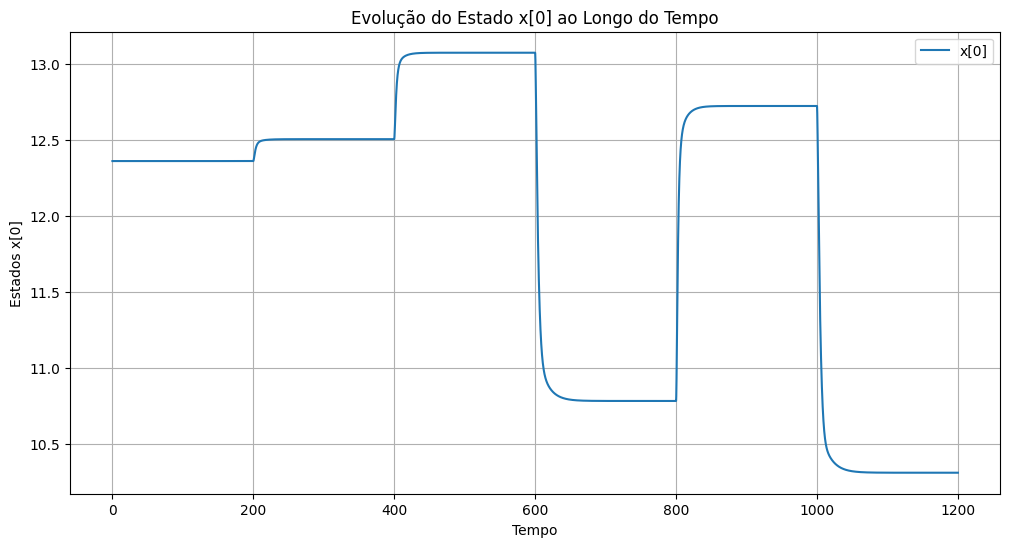

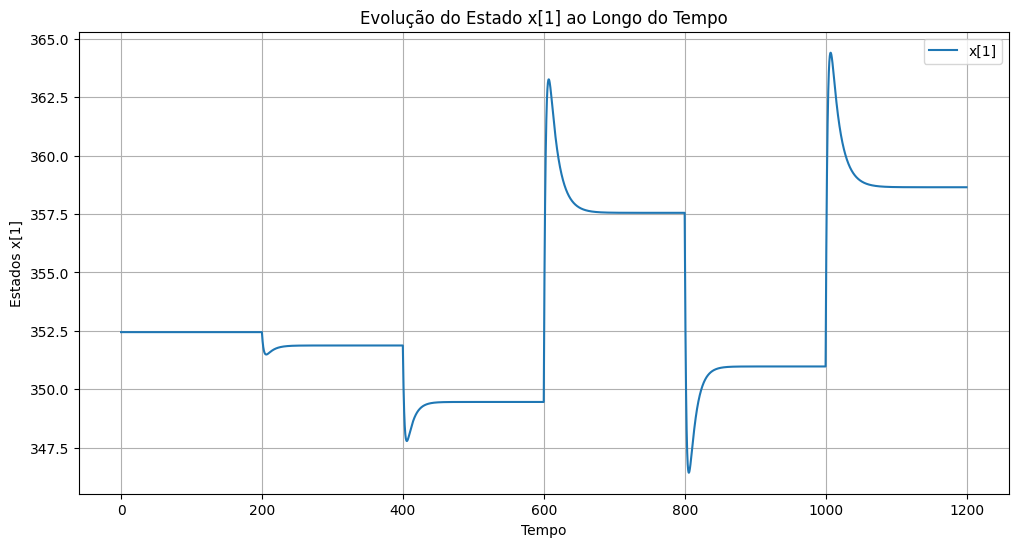

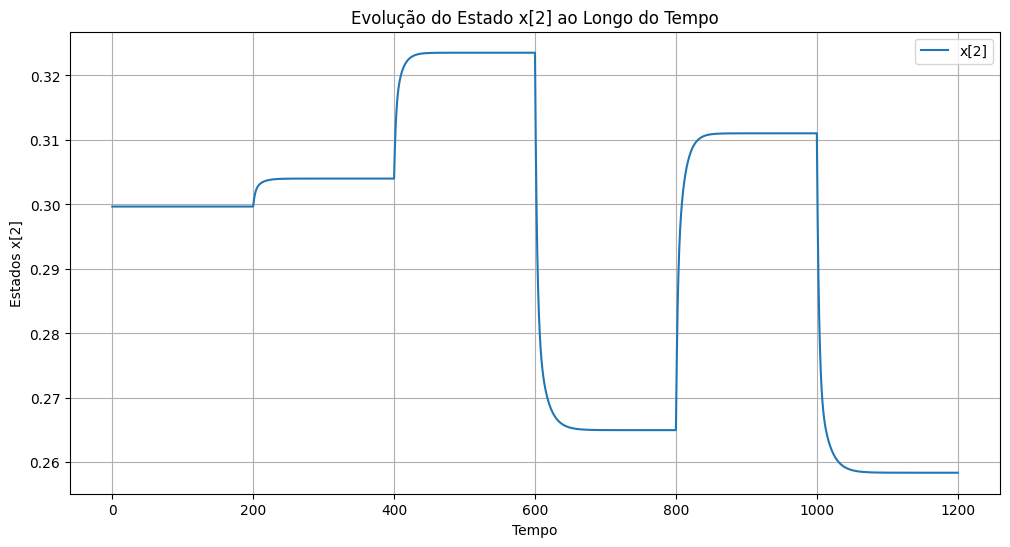

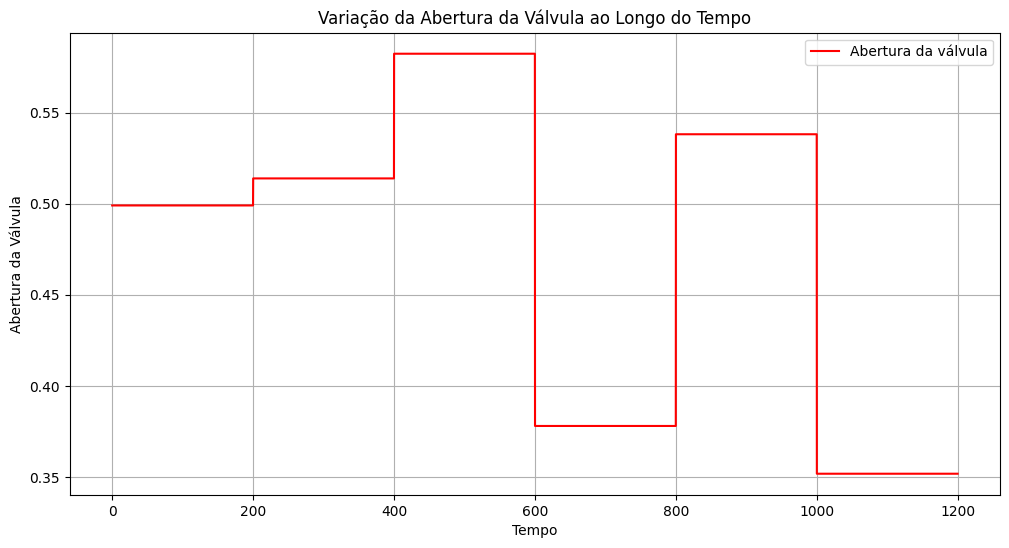

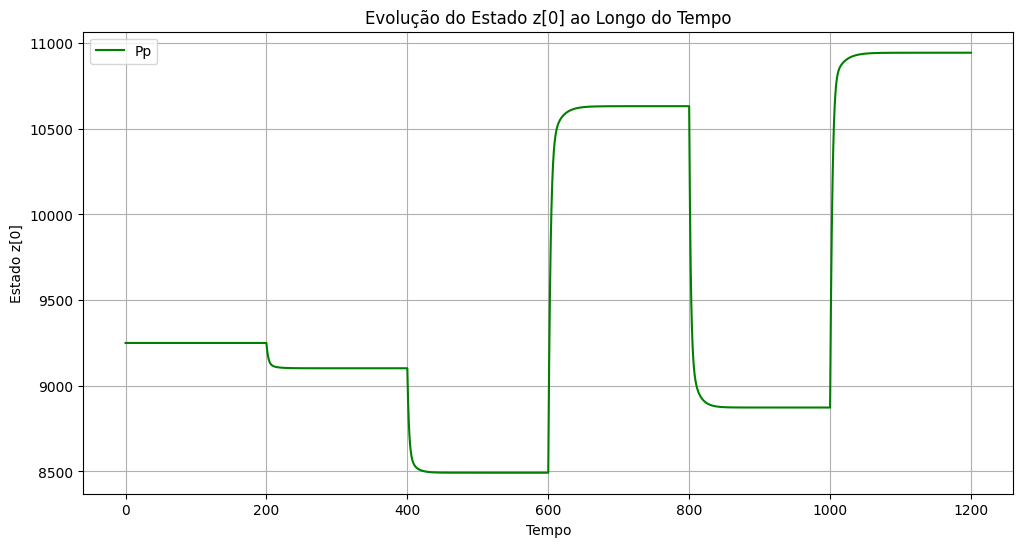

(array([[1.03079723e+01],
        [3.58645785e+02],
        [2.58395807e-01]]),
 array([[1.09433147e+04],
        [1.09433147e+04],
        [3.24778729e+02],
        [4.12698887e-01],
        [3.24248880e+02],
        [4.20255858e-01],
        [3.53860866e+02],
        [2.53624710e-01],
        [3.58645781e+02],
        [2.58395803e-01],
        [5.14917237e-01]]))

In [6]:
from casadi import SX, vertcat, integrator
import numpy as np
import matplotlib.pyplot as plt

def run_simulation(x0, z0, plenum_sys, alphas, nAlphas, nData):
    u0 = [4500, 300, 750, 0.65, 5000]
    dt = 0.1  # Passo de tempo
    
    # Definição dos símbolos
    x_sym = SX.sym('x', 3)
    z_sym = SX.sym('z', 11)
    u_sym = SX.sym('u', 5)
    
    # Avaliação do DAE
    ode_sym, alg_sym = plenum_sys.evaluate_dae(None, x_sym, z_sym, u_sym)
    dae = {
        'x': x_sym,
        'z': z_sym,
        'p': u_sym,
        'ode': vertcat(*ode_sym),
        'alg': vertcat(*alg_sym)
    }
    
    integrator_solver = integrator('F', 'idas', dae, {'tf': dt})
    
    # Listas para armazenar os resultados
    time_steps = []
    x_values = []
    z_values = []
    alpha_values = []
    
    time = 0
    
    for i in range(nAlphas):
        u0[3] = alphas[i]  # Atualiza a abertura da válvula
        alpha_value = alphas[i] + np.random.normal(0, 0, nData)
        
        for j in range(nData):
            res = integrator_solver(x0=x0, z0=z0, p=u0)
            
            # Atualiza x0 e z0 para o próximo passo
            x0 = np.array(res["xf"])
            z0 = np.array(res["zf"])
            
            # Armazena os valores
            time_steps.append(time)
            x_values.append(x0.copy())
            z_values.append(z0.copy())
            alpha_values.append(u0[3])
            
            time += dt
    
    # Converter listas para arrays para facilitar o plot
    x_values = np.array(x_values)
    z_values = np.array(z_values)
    alpha_values = np.array(alpha_values)
    
    # Plotando os resultados
    plt.figure(figsize=(12, 6))
    
    # Plot de x
# Plotando os estados x em gráficos separados
    for i in range(x_values.shape[1]):
        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, x_values[:, i], label=f'x[{i}]')
        plt.xlabel('Tempo')
        plt.ylabel(f'Estados x[{i}]')
        plt.title(f'Evolução do Estado x[{i}] ao Longo do Tempo')
        plt.legend()
        plt.grid()
        plt.show()

# Plotando a abertura da válvula em um gráfico separado
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, alpha_values, label='Abertura da válvula', color='red')
    plt.xlabel('Tempo')
    plt.ylabel('Abertura da Válvula')
    plt.title('Variação da Abertura da Válvula ao Longo do Tempo')
    plt.legend()
    plt.grid()
    plt.show()

    # Plotando z[0] em um gráfico separado
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, z_values[:, 0], label='Pp', color='green')
    plt.xlabel('Tempo')
    plt.ylabel('Estado z[0]')
    plt.title('Evolução do Estado z[0] ao Longo do Tempo')
    plt.legend()
    plt.grid()
    plt.show()

    
    return x0, z0

# Exemplo de chamada da função (x_ss e z_ss devem estar definidos anteriormente)
run_simulation(x_ss, z_ss, plenum_sys, alphas, nAlphas, nData)
